---
# Trimming and Filtering"

### Questions:
- How can we get rid of sequence data that does not meet our quality standards?

### Objectives:
- Clean FASTQ reads using Trimmomatic.
- Select and set multiple options for command line bioinformatic tools.
- Write `for` loops with two variables.

### Keypoints:
- The options you set for the command-line tools you use are important!
- Data cleaning is essential at the beginning of metagenomics workflows.
- Use Trimmomatic to get rid of adapters and low-quality bases or reads.
- Carefully fill in the parameters and options required to call a function in the bash shell.
- Automate repetitive workflows using for loops.

---

## Getting Started

In [ ]:
# set the variables for your netid
netid = "NETID"

In [ ]:
# Go into the working directory
work_dir = "/xdisk/bhurwitz/bh_class/" + netid + "/exercises/06_qc_trimming"
%cd $work_dir

In [ ]:
# Create a variable for the data directory
data_dir = "/xdisk/bhurwitz/bh_class/" + netid + "/exercises/data/untrimmed_fastq"

## Cleaning reads

In the last exercise, we took a high-level look at the quality of each of our samples using `FastQC`. We visualized per-base quality graphs showing the distribution of the quality at each base across all the reads from our sample. This information helps us to determine 
the quality threshold we will accept, and thus, we saw information about which samples fail which quality checks. Some of our samples failed quite a few quality metrics used by FastQC. However, this does not mean that our samples should be thrown out! It is common to have some 
quality metrics fail, which may or may not be a problem for your downstream application. For our workflow, we will remove some low-quality sequences to reduce our false-positive rate due to sequencing errors.

To accomplish this, we will use a program called [Trimmomatic](http://www.usadellab.org/cms/?page=trimmomatic). This useful tool filters poor quality reads and trims poor quality bases 
from the specified samples.


## Trimmomatic options

Trimmomatic has a variety of options to accomplish its task. 
If we run the following command, we can see some of its options:

!apptainer run /contrib/singularity/shared/bhurwitz/trimmomatic:0.39--hdfd78af_2.sif trimmomatic --help

#### What do you get?

You should see the following output:

```
Usage: 
       PE [-version] [-threads <threads>] [-phred33|-phred64] [-trimlog <trimLogFile>] [-summary <statsSummaryFile>] [-quiet] [-validatePairs] [-basein <inputBase> | <inputFile1> <inputFile2>] [-baseout <outputBase> | <outputFile1P> <outputFile1U> <outputFile2P> <outputFile2U>] <trimmer1>...
   or: 
       SE [-version] [-threads <threads>] [-phred33|-phred64] [-trimlog <trimLogFile>] [-summary <statsSummaryFile>] [-quiet] <inputFile> <outputFile> <trimmer1>...
   or: 
       -version
```


This output shows that we must first specify whether we have paired-end (`PE`) or single-end (`SE`) reads. Next, we will specify with which flags we want to run Trimmomatic. For example, you can specify `threads` to indicate the number of processors on your computer that you want Trimmomatic to use. In most cases, using multiple threads(processors) can help to run the 
trimming faster. These flags are unnecessary, but they can give you more control over the command. The flags are followed by **positional arguments**, meaning the order in which you specify them is essential. In paired-end mode, Trimmomatic expects the two input files and then the names of the output files. These files are described below. While in single-end mode, Trimmomatic will expect one file as input, after which you can enter the optional settings and, lastly, the name of the output file.

| Option    | Meaning |  
| ------- | ---------- |  
|  \<inputFile1>  | input forward reads to be trimmed. Typically the file name will contain an `_1` or `_R1` in the name.|  
| \<inputFile2> | Input reverse reads to be trimmed. Typically the file name will contain an `_2` or `_R2` in the name.|  
|  \<outputFile1P> | Output file that contains surviving pairs from the `_1` file. |  
|  \<outputFile1U> | Output file that contains orphaned reads from the `_1` file. |  
|  \<outputFile2P> | Output file that contains surviving pairs from the `_2` file.|  
|  \<outputFile2U> | Output file that contains orphaned reads from the `_2` file.|  
  
The last thing Trimmomatic expects to see is the trimming parameters:

| step   | meaning |  
| ------- | ---------- |  
| `ILLUMINACLIP` | Perform adapter removal. |  
| `SLIDINGWINDOW` | Perform sliding window trimming, cutting once the average quality within the window falls below a threshold. |  
| `LEADING`  | Cut bases off the start of a read if below a threshold quality.  |  
|  `TRAILING` |  Cut bases off the end of a read if below a threshold quality. |  
| `CROP`  |  Cut the read to a specified length. |  
|  `HEADCROP` |  Cut the specified number of bases from the start of the read. |  
| `MINLEN`  |  Drop an entire read if it is below a specified length. |  
|  `TOPHRED33` | Convert quality scores to Phred-33.  |  
|  `TOPHRED64` |  Convert quality scores to Phred-64. |  

Understanding the steps you are using to
clean your data is essential. We will use only a few options and trimming steps in our
analysis. For more information about the Trimmomatic arguments
and options, see [the Trimmomatic manual](http://www.usadellab.org/cms/uploads/supplementary/Trimmomatic/TrimmomaticManual_V0.32.pdf).



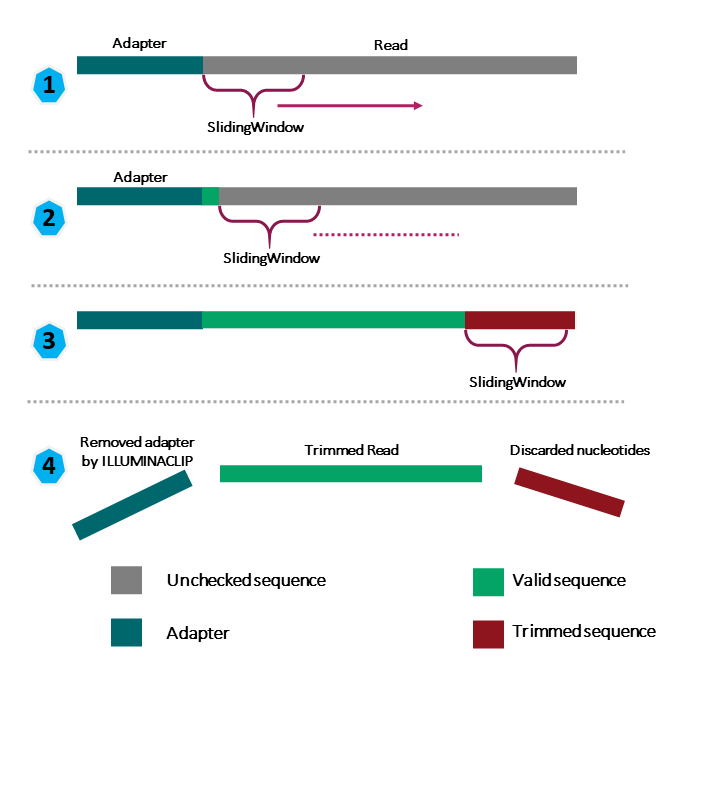

Diagram showing the parts of the sequence that are reviewed by each parameter and the parts that are maintained or discarded at the end of the process. The Illuminaclip parameter removes the adapters, and the SlidingWindow scans the read by sections and removes a part of the read below the quality threshold. We remain with a trimmed read that has a valid quality.

### What is this command line?

In this example, we have told Trimmomatic:

| code   | meaning |
| ------- | ---------- |
| `PE` | that it will be taking a paired-end file as input |
| `-threads 4` | to use four computing threads to run (this will speed up our run) |
| `SRR_1056_1.fastq` | the first input file name. Forward |
| `SRR_1056_2.fastq` | the second input file name. Reverse |
| `SRR_1056_1.trimmed.fastq` | the output file for surviving pairs from the `_1` file |
| `SRR_1056_1un.trimmed.fastq` | the output file for orphaned reads from the `_1` file |
| `SRR_1056_2.trimmed.fastq` | the output file for surviving pairs from the `_2` file |
| `SRR_1056_2un.trimmed.fastq` | the output file for orphaned reads from the `_2` file |
| `ILLUMINACLIP:SRR_adapters.fa`| to clip the Illumina adapters from the input file using the adapter sequences listed in `SRR_adapters.fa` |
|`SLIDINGWINDOW:4:20` | to use a sliding window of size 4 that will remove bases if their Phred score is below 20 |

> ## Multi-line for long commands 
> Some of the commands we ran in this lesson are long! To separate code chunks onto separate lines
>  When typing into your terminal one command with long input or many modifying parameters, you can
>   use the `\` character to make your code more readable. For example, let us use multi lines 
>   with the echo command. With `\` it is possible to use several lines to print "hello world" 
>   on your terminal.

> ```
> $ echo he\
> $ llo\
> $ world
> ```

> ```
> $ hello world
> ```

> Note: Some terminals only wait a few seconds for you to keep typing. In that case, you may write 
> down the full command in a text file and then copy it to your terminal.

## Running Trimmomatic

Now, we will run Trimmomatic on our data. Navigate to your `untrimmed_fastq` data directory and verify that you are located in the `untrimmed_fastq/` directory:

In [ ]:
%cd $data_dir
!pwd
!ls

#### What did you get?

You should have only four files in this directory. Those files correspond
to the files of forward and reverse reads from samples JC1A and JP4D.

```
$ JC1A_R1.fastq.gz  JC1A_R2.fastq.gz  JP4D_R1.fastq  JP4D_R2.fastq.gz  TruSeq3-PE.fa   
```

We are going to run Trimmomatic on one of our paired-end samples. 
While using FastQC, we saw that Universal adapters were present in our samples. The adapter sequences came with the installation of Trimmomatic and it is located in our current directory in the file `TruSeq3-PE.fa`.

We will also use a sliding window of size 4 that will remove bases if theirPhred score is below 20 (like in our example above). We will alsodiscard any reads that do not have at least 25 bases remaining after this trimming step. This command will take a few minutes to run.

Before, we unzipped one of our files to work with it. Let us compress the file corresponding to the sample `JP4D` again before we run Trimmomatic.

In [ ]:
!gzip JP4D_R1.fastq

!apptainer run /contrib/singularity/shared/bhurwitz/trimmomatic:0.39--hdfd78af_2.sif trimmomatic \
PE JP4D_R1.fastq.gz JP4D_R2.fastq.gz \
JP4D_R1.trim.fastq.gz  JP4D_R1un.trim.fastq.gz \
JP4D_R2.trim.fastq.gz  JP4D_R2un.trim.fastq.gz \
SLIDINGWINDOW:4:20 MINLEN:35 ILLUMINACLIP:TruSeq3-PE.fa:2:40:15

#### You should see something like this...

```
TrimmomaticPE: Started with arguments:
 JP4D_R1.fastq.gz JP4D_R2.fastq.gz JP4D_R1.trim.fastq.gz JP4D_R1un.trim.fastq.gz JP4D_R2.trim.fastq.gz JP4D_R2un.trim.fastq.gz SLIDINGWINDOW:4:20 MINLEN:35 ILLUMINACLIP:TruSeq3-PE.fa:2:40:15
Multiple cores found: Using 2 threads
Using PrefixPair: 'TACACTCTTTCCCTACACGACGCTCTTCCGATCT' and 'GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCT'
ILLUMINACLIP: Using 1 prefix pairs, 0 forward/reverse sequences, 0 forward only sequences, 0 reverse only sequences
Quality encoding detected as phred33
Input Read Pairs: 1123987 Both Surviving: 751427 (66.85%) Forward Only Surviving: 341434 (30.38%) Reverse Only Surviving: 11303 (1.01%) Dropped: 19823 (1.76%)
TrimmomaticPE: Completed successfully
```


> ## Exercise 1: What did Trimmomatic do?
>
> Use the output from your Trimmomatic command to answer the
> following questions.
>
> 1) What percent of reads did we discard from our sample?  
> 2) What percent of reads did we keep both pairs?
>
<details>
  <summary markdown="span">Solution</summary>
  <ul> 
1) 1.76%    
2) 66.85%
</details>

<br>

You may have noticed that Trimmomatic automatically detected the
quality encoding of our sample. It is always a good idea to
double-check this or manually enter the quality encoding.

We can confirm that we have our output files:

In [ ]:
!ls JP4D*

#### You should see something like this...

```
JP4D_R1.fastq.gz       JP4D_R1un.trim.fastq.gz	JP4D_R2.trim.fastq.gz
JP4D_R1.trim.fastq.gz  JP4D_R2.fastq.gz		JP4D_R2un.trim.fastq.gz
```

The output files are also FASTQ files. It should be smaller than our
input file because we have removed reads. We can confirm this with this
command:

In [ ]:
!ls JP4D* -l -h

#### You should see something like this ...

```
-rw-r--r-- 1 dcuser dcuser 179M Nov 26 12:44 JP4D_R1.fastq.gz
-rw-rw-r-- 1 dcuser dcuser 107M Mar 11 23:05 JP4D_R1.trim.fastq.gz
-rw-rw-r-- 1 dcuser dcuser  43M Mar 11 23:05 JP4D_R1un.trim.fastq.gz
-rw-r--r-- 1 dcuser dcuser 203M Nov 26 12:51 JP4D_R2.fastq.gz
-rw-rw-r-- 1 dcuser dcuser 109M Mar 11 23:05 JP4D_R2.trim.fastq.gz
-rw-rw-r-- 1 dcuser dcuser 1.3M Mar 11 23:05 JP4D_R2un.trim.fastq.gz
```


We have just successfully run Trimmomatic on one of our FASTQ files!
However, there is some bad news. Trimmomatic can only operate on
one sample at a time, and we have more than one sample. The good news
is that we can use a `for` loop to iterate through our sample files
quickly! 

In [ ]:
# Let's create the script to run a for loop

my_code = '''#! /bin/bash

for infile in *_R1.fastq.gz
do
base=$(basename ${infile} _R1.fastq.gz)
apptainer run /contrib/singularity/shared/bhurwitz/trimmomatic:0.39--hdfd78af_2.sif trimmomatic \
PE ${infile} ${base}_R2.fastq.gz \
${base}_R1.trim.fastq.gz ${base}_R1un.trim.fastq.gz \
${base}_R2.trim.fastq.gz ${base}_R2un.trim.fastq.gz \
SLIDINGWINDOW:4:20 MINLEN:35 ILLUMINACLIP:TruSeq3-PE.fa:2:40:15
done

'''

with open('run_trimmomatic.sh', mode='w') as file:
    file.write(my_code)

In [ ]:
!chmod +x run_trimmomatic.sh

#### Run it!

Go ahead and run the `for` loop. It should take a few minutes for Trimmomatic to run for each of our four input files. Once it is done, take a look at your directory contents. You will notice that even though we ran Trimmomatic on file `JP4D` before running the for loop, there is only one set of files for it. Because we matched the ending `_R1.fastq.gz`, we re-ran Trimmomatic on this file, overwriting our first results. That is ok, but it is good to be aware that it happened.

In [ ]:
!./run_trimmomatic.sh

In [ ]:
!ls

#### What did you get?

```
JC1A_R1.fastq.gz                     JP4D_R1.fastq.gz                                    
JC1A_R1.trim.fastq.gz                JP4D_R1.trim.fastq.gz                                
JC1A_R1un.trim.fastq.gz              JP4D_R1un.trim.fastq.gz                                
JC1A_R2.fastq.gz                     JP4D_R2.fastq.gz                                 
JC1A_R2.trim.fastq.gz                JP4D_R2.trim.fastq.gz                                 
JC1A_R2un.trim.fastq.gz              JP4D_R2un.trim.fastq.gz                                 
TruSeq3-PE.fa   
```

We have completed the trimming and filtering steps of our quality
control process! Before we move on, let us move our trimmed FASTQ files to our results directory

In [ ]:
%cd $data_dir
!mv *.trim* $work_dir
%cd $work_dir
!ls

#### what did you get?

You should see something like this...

```
JC1A_R1.trim.fastq.gz    JP4D_R1.trim.fastq.gz                
JC1A_R1un.trim.fastq.gz  JP4D_R1un.trim.fastq.gz              
JC1A_R2.trim.fastq.gz    JP4D_R2.trim.fastq.gz                
JC1A_R2un.trim.fastq.gz  JP4D_R2un.trim.fastq.gz   
```

## The End

Copy your notebook for future reference

In [ ]:
!cp ~/be487-fall-2024/exercises/06_qc_trimming/ex06_02-trimming-filtering.ipynb $work_dir